# package, def load

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import time
import gym
import pandas as pd
import numpy as np


import joblib
import os
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import random 
import math
from pandas import DataFrame
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle
import copy
import random

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # Don't use all GPUs 
config.allow_soft_placement = True  # Enable manual control
tf.config.list_physical_devices('GPU')

Instructions for updating:
non-resource variables are not supported in the long term


[]

In [2]:
import pickle
import pandas as pd

def my_save(List,filename,Global):
    # filename : name.pkl
    my_pickle = {}
    for key in List:
        try:
            my_pickle[key] = Global[key] #globals()[key]
        except TypeError:
            print('ERROR pickleing: {0}'.format(key))
    with open(filename, 'wb') as f:   # Python 3: open(..., 'wb')
        pickle.dump(my_pickle, f)


def my_load(filename,Global):
    with open(filename, 'rb') as f:  # Python 3: open(..., 'rb')
        my_shelf = pickle.load(f)

    for key in my_shelf:
        Global[key] = my_shelf[key]

# data load

In [3]:
dirname = "S_R8/"
mimic_dir = "/public/hanl/jupyter_dir/ir_recommend_v2/04.merge/" + dirname
print(os.listdir(mimic_dir))

df_train = pd.read_csv(mimic_dir + '/train_data.csv')
#df_train.loc[(df_train["reward"]==-40),"reward"] = -100 # 163条
df_val = pd.read_csv(mimic_dir + '/val_data.csv')
df_test = pd.read_csv(mimic_dir + '/test_data.csv')

df_all = pd.read_csv(mimic_dir + '/all_data.csv')
df_all = df_all.sort_values(["traj_id","starttime"])
df_all["last_rate"].fillna(0,inplace=True)

df_train = df_train[df_train["idx"] != max(df_all["idx"])]

df_train.index = pd.RangeIndex(len(df_train.index))
df_val.index = pd.RangeIndex(len(df_val.index))
df_test.index = pd.RangeIndex(len(df_test.index))
print(df_test.shape)

['all_data.csv', 'train_data.csv', 'val_data.csv', 'test_data.csv']
(12, 273)


# parameter setting 

## data parapmeter

In [4]:
no_state_features = [ 'stay_id',
                     'traj_id','heart_rate_mean.1', 'resp_rate_mean.1',
 'reward',"idx",
 'rate', 'rate_bin',
 'next_glucose_max', 'next_glucose_min','next_glucose_mean'
]
state_features = list(set(df_train.columns.tolist()) - set(no_state_features))
reward_features = ['reward']
action_features = ["rate_bin"]

REWARD_THRESHOLD_max = 21
REWARD_THRESHOLD_min = -41
REWARD_THRESHOLD = max(abs(REWARD_THRESHOLD_max), abs(REWARD_THRESHOLD_min))

- buffer reply
- https://github.com/jcborges/dqn-per/blob/master/DQN.py

# get SAR

## action to bin

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


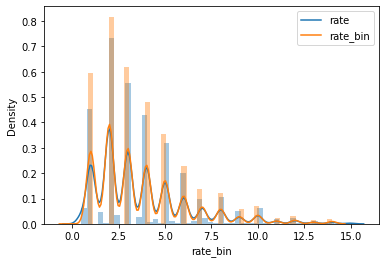

In [5]:
import seaborn as sns
sns.distplot(df_train["rate"])
sns.distplot(df_train["rate_bin"])
plt.legend(["rate", "rate_bin"])

## batch SAR

In [6]:
# 这块要求dataframe 按时间从小到大排序
def process_train_batch(size, df):
    df_all_ = df_all.copy()
    df = df[df["idx"] != max(df_all_["idx"])]
    if geometric_sampling == True:
        a = df.sample(n=size, weights = df.groupby('rate_bin')['rate_bin'].transform('count'))
    else:
        a = df.sample(n=size)
    states = None
    actions = None
    rewards = None
    next_states = None

    for i in a.index:
        cur_state = a.loc[i,state_features]
        action = a.loc[i,'rate_bin']
        reward = a.loc[i,'reward']
        traj = a.loc[i,"traj_id"]
        
        idx_num = a.loc[i,"idx"]
        
        if df_all_.loc[idx_num, 'traj_id'] == df_all_.loc[idx_num+1, 'traj_id']:
            next_state = df_all_.loc[idx_num+1, state_features]
        else:
            next_state = np.zeros(len(cur_state))
                
        if clip_reward:
            if reward > REWARD_THRESHOLD_max: reward = REWARD_THRESHOLD_max
            if reward < REWARD_THRESHOLD_min: reward = REWARD_THRESHOLD_min

        if states is None:
            states = copy.deepcopy(cur_state)
        else:
            states = np.vstack((states,cur_state))

        if actions is None:
            actions = [action]
        else:
            actions = np.vstack((actions,action))

        if rewards is None:
            rewards = [reward]
        else:
            rewards = np.vstack((rewards,reward))

        if next_states is None:
            next_states = copy.deepcopy(next_state)
        else:
            next_states = np.vstack((next_states,next_state))
    
    return (states, np.squeeze(actions), np.squeeze(rewards), next_states, a)


In [7]:
# extract chunks of length size from the relevant dataframe, and yield these to the caller
def process_eval_batch(batch_size, eval_type = None):
    df_all_ = df_all.copy()
    if eval_type is None:
        raise Exception('Provide eval_type to process_eval_batch')
    elif eval_type == 'train':
       # 
        a = df_train.copy()
    elif eval_type == 'val':
        a = df_val.copy()
    elif eval_type == 'test':
        a = df_test.copy()
    else:
        raise Exception('Unknown eval_type')
    count = 0
    while count < len(a.index):
        states = None
        actions = None
        rewards = None
        next_states = None

        start_idx = count
        end_idx = min(len(a.index), count+batch_size)
        segment = a.index[start_idx:end_idx]
        
        for i in segment:
            cur_state = a.loc[i,state_features]
            action = a.loc[i, 'rate_bin']
            reward = a.loc[i,'reward']
            
            idx_num = a.loc[i,"idx"]
            if df_all_.loc[idx_num, 'traj_id'] == df_all_.loc[idx_num+1, 'traj_id']:
                next_state = df_all_.loc[idx_num+1, state_features]
            else:
                next_state = np.zeros(len(cur_state))
            
            if clip_reward:
                if reward > REWARD_THRESHOLD_max: reward = REWARD_THRESHOLD_max
                if reward < REWARD_THRESHOLD_min: reward = REWARD_THRESHOLD_min

            if states is None:
                states = copy.deepcopy(cur_state)
            else:
                states = np.vstack((states,cur_state))

            if actions is None:
                actions = [action]
            else:
                actions = np.vstack((actions,action))

            if rewards is None:
                rewards = [reward]
            else:
                rewards = np.vstack((rewards,reward))

            if next_states is None:
                next_states = copy.deepcopy(next_state)
            else:
                next_states = np.vstack((next_states,next_state))

        yield (states, np.squeeze(actions), np.squeeze(rewards), next_states,  a)
        
        count += batch_size

# main

## def for main

In [8]:
num_actions = len(df_train["rate_bin"].unique())
state_dim = len(state_features)
max_rate_bin = max(df_train["rate_bin"])

print(num_actions, state_dim, max_rate_bin)

15 262 14


In [9]:
hidden_1_size = 200
hidden_2_size = 100
#  Q-network uses Leaky ReLU activation
class Qnetwork():
    def __init__(self):
        self.phase = tf.placeholder(tf.bool)
        self.num_actions = num_actions
        self.input_size = state_dim
        self.batch_size = batch_size
        self.state = tf.placeholder(tf.float32, shape=[None, self.input_size],name="input_state")
        self.actions_max = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions_min = tf.placeholder(shape=[None],dtype=tf.float32)
        
        self.fc_1 = tf.compat.v1.layers.dense(self.state, hidden_1_size, activation=None)
        self.fc_2 = tf.compat.v1.layers.dense(self.fc_1, hidden_2_size, activation=None)
        # advantage and value streams
        self.streamA, self.streamV = tf.split(self.fc_2, 2, axis=1)
        self.AW = tf.Variable(tf.random_normal([hidden_2_size//2, self.num_actions]))
        self.VW = tf.Variable(tf.random_normal([hidden_2_size//2, 1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.q_output = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        #if probs > epsilon:
        self.predict_fix = tf.argmax(self.q_output, 1, name='predict')
       # else:
        self.dims2 = tf.shape(tf.multinomial(tf.log(self.q_output),1))[0]
       # self.predict_ran = tf.squeeze(tf.random_uniform((self.dims2, 1), minval=0, maxval= num_actions, dtype=tf.int32), axis=1)
        self.predict_ran = tf.compat.v1.to_int32(tf.diag_part(tf.random_uniform((self.dims2, 1), minval=self.actions_min, maxval=self.actions_max,dtype=tf.float32)))
        
        #Below we obtain the loss by taking the sum of squares difference between the target and predicted Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,self.num_actions,dtype=tf.float32) # actions维度为batch_size*1 hotencoding后为32*29

        # select the Q values for the actions that would be selected         
        self.Q = tf.reduce_sum(tf.multiply(self.q_output, self.actions_onehot), reduction_indices=1) # 每个横轴上输出一个值
        self.abs_error = tf.abs(self.targetQ - self.Q)
        self.td_error = tf.square(self.targetQ - self.Q)
        self.old_loss = tf.reduce_mean(self.td_error)

    #    if per_flag:
     #       self.loss = tf.reduce_mean(self.per_error) + reg_lambda*self.reg_term
     #   else:
        self.reg_vector = tf.maximum(tf.abs(self.Q)-REWARD_THRESHOLD,0) # regularisation penalises the network when it produces rewards that are above the reward threshold, to ensure reasonable Q-value predictions 
        self.reg_term = tf.reduce_sum(self.reg_vector)
        self.loss = self.old_loss + reg_lambda*self.reg_term

        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(self.update_ops):
            self.update_model = self.trainer.minimize(self.loss) # 最小化loss

# function is needed to update parameters between main and target network
# tf_vars are the trainable variables to update, and tau is the rate at which to update
# returns tf ops corresponding to the updates
def update_target_graph(tf_vars,tau):
    total_vars = len(tf_vars)
    op_holder = []
    for idx,var in enumerate(tf_vars[0:int(total_vars/2)]):
        op_holder.append(tf_vars[idx+int(total_vars/2)].assign((var.value()*tau) + ((1-tau)*tf_vars[idx+int(total_vars/2)].value())))
    return op_holder

def update_target(op_holder,sess):
    for op in op_holder:
        sess.run(op)

## do_eval

In [10]:
def do_eval(eval_type, batch_size):
    gen = process_eval_batch(batch_size = batch_size, eval_type=eval_type)
    iternum = 40
    random_q_ret = []
    phys_q_ret = []
    actions_ret = []
    agent_q_ret = []
    actions_taken_ret = []
    error_ret = 0

    for b in gen:
        probs = np.array(random.random()) 
        states,actions,rewards,next_states, _ = b
        actions_min = actions - max_rate_bin
        actions_min[actions_min<=0] = 0
        actions_max = actions + max_rate_bin
        actions_max[actions_max>=max_rate_bin] = max_rate_bin
       # if probs > epsilon:
        actions_from_q1 = sess.run(mainQN.predict_fix,feed_dict={mainQN.state:next_states, mainQN.phase : 0})
        cur_act = sess.run(mainQN.predict_fix, feed_dict={mainQN.state:states, mainQN.phase : 0})
       # else:
       #     actions_from_q1 = sess.run(mainQN.predict_ran,feed_dict={mainQN.state:next_states, mainQN.phase : 0})
            
        Q1 = sess.run(targetQN.q_output,feed_dict={targetQN.state:next_states, targetQN.phase : 0})
        for j in range(1,iternum,1): 
            Q2 = sess.run(targetQN.q_output,feed_dict={targetQN.state:next_states, targetQN.phase : 0})
            Q1 = np.dstack((Q1, Q2))
        Q2 = np.mean(Q1, axis=2)
        
        # target Q value using Q values from target, and actions from main
        double_q_value = Q2[range(len(Q2)), actions_from_q1]
      #  print(double_q_value.shape)
        # empirical hack to make the Q values never exceed the threshold - helps learning
      #  double_q_value[double_q_value > REWARD_THRESHOLD_max] = REWARD_THRESHOLD_max
      #  double_q_value[double_q_value < REWARD_THRESHOLD_min] = REWARD_THRESHOLD_min
        
        
        # definition of target Q
        targetQ = rewards + (gamma*double_q_value)

        # get the output q's, actions, and loss
        q_output,actions_taken, abs_error = sess.run([mainQN.q_output, mainQN.predict_fix, mainQN.abs_error], \
                feed_dict={mainQN.state:states,
                           mainQN.targetQ:targetQ, 
                           mainQN.actions:cur_act,
                           mainQN.phase:False
                          })
        random_act = sess.run(mainQN.predict_ran, feed_dict={mainQN.state:states,  mainQN.actions_min:actions_min, mainQN.actions_max:actions_max, mainQN.phase : 0})
        
        random_q = q_output[range(len(q_output)), random_act]
        phys_q = q_output[range(len(q_output)), actions.astype('int64')]
        agent_q = q_output[range(len(q_output)), actions_taken] # actions_taken为mainQN.predict的结果
        error = np.mean(abs_error)
        
        # update the return vals
        phys_q_ret.extend(phys_q)
        random_q_ret.extend(random_q)
        actions_ret.extend(actions)        
        agent_q_ret.extend(agent_q)
        actions_taken_ret.extend(actions_taken)
        error_ret += error
  
    return random_q_ret, phys_q_ret, actions_ret, agent_q_ret, actions_taken_ret, error_ret

## do_save

In [11]:
def do_save_results():
    # get the chosen actions for the train, val, and test set when training is complete.
    ran_q, phys_q_train, phys_actions_train, agent_q_train, agent_actions_train, _ = do_eval(batch_size=100, eval_type = 'train')
#    print ("length of training epoch ", len(agent_actions_train))
  #  with open(save_dir + 'dqn_normal_actions_train.p', 'wb') as f:
  #      pickle.dump(agent_actions_train, f)
    ran_q, phys_q_val, phys_actions_val, agent_q_val, agent_actions_val, _ = do_eval(batch_size=100, eval_type = 'val')        
    ran_q, phys_q_test, phys_actions_test, agent_q_test, agent_actions_test, _ = do_eval(batch_size=100, eval_type = 'test')   
    
    # save everything for later - they're used in policy evaluation and when generating plots
    with open(save_dir + 'dqn_normal_actions_train.p', 'wb') as f:
        pickle.dump(agent_actions_train, f)
    with open(save_dir + 'dqn_normal_actions_val.p', 'wb') as f:
        pickle.dump(agent_actions_val, f)
    with open(save_dir + 'dqn_normal_actions_test.p', 'wb') as f:
        pickle.dump(agent_actions_test, f)

    with open(save_dir + 'dqn_normal_phy_actions_train.p', 'wb') as f:
        pickle.dump(phys_actions_train, f)
    with open(save_dir + 'dqn_normal_phy_actions_val.p', 'wb') as f:
        pickle.dump(phys_actions_val, f)
    with open(save_dir + 'dqn_normal_phy_actions_test.p', 'wb') as f:
        pickle.dump(phys_actions_test, f)
        
    with open(save_dir + 'dqn_normal_q_train.p', 'wb') as f:
        pickle.dump(agent_q_train, f)
    with open(save_dir + 'dqn_normal_q_val.p', 'wb') as f:
        pickle.dump(agent_q_val, f)
    with open(save_dir + 'dqn_normal_q_test.p', 'wb') as f:
        pickle.dump(agent_q_test, f)
    
    with open(save_dir + 'dqn_normal_phy_q_train.p', 'wb') as f:
        pickle.dump(phys_q_train, f)
    with open(save_dir + 'dqn_normal_phy_q_val.p', 'wb') as f:
        pickle.dump(phys_q_val, f)
    with open(save_dir + 'dqn_normal_phy_q_test.p', 'wb') as f:
        pickle.dump(phys_q_test, f)
        
    return

## training

In [12]:
"""av_loss_step = []
av_loss_lst = []

av_q_step = []
av_agent_q_lst = []
av_phys_q_lst = []
av_phys_q_std_lst = []
av_agent_q_std_lst = []
av_ran_q_lst = []
av_ran_q_std_lst = []
    
M_phy_ac = []
E_phy_ac = []
EA_phy_ac = []
L_phy_ac = []

err_lst = [] """

'av_loss_step = []\nav_loss_lst = []\n\nav_q_step = []\nav_agent_q_lst = []\nav_phys_q_lst = []\nav_phys_q_std_lst = []\nav_agent_q_std_lst = []\nav_ran_q_lst = []\nav_ran_q_std_lst = []\n    \nM_phy_ac = []\nE_phy_ac = []\nEA_phy_ac = []\nL_phy_ac = []\n\nerr_lst = [] '

In [13]:
df = df_train
spea_action = df["rate_bin"].unique().tolist()

geometric_sampling = True

tf.compat.v1.reset_default_graph()
reg_lambda = 5
#per_flag = True # per_flag 是决定是否根据优先度权重构建样本
clip_reward = True

# The main training loop is here
batch_size = 256
tau = 0.05 #Rate to update target network toward primary network
gamma = 0.99 # discount factor  # 只考虑后面的两步，更注重当下利益

load_model = False # Whether to load a saved model.
save_dir = "./dqn_normal_noterm_R8_v1_t1/"
save_path = "./dqn_normal_noterm_R8_v1_t1/ckpt" #The path to save our model to.
epsilon = 0.9 # epsilon_greedy
bak_epsilon = epsilon
num_steps = 90000 # How many steps to train for
iternum = 10 

mainQN = Qnetwork()
targetQN = Qnetwork()

saver = tf.train.Saver(tf.global_variables()) 
init = tf.global_variables_initializer() 
trainables = tf.trainable_variables() # 查看模型训练过程中的一些参数
target_ops = update_target_graph(trainables,tau)

#Make a path for our model to be saved in.
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
with tf.Session(config=config) as sess:
    if load_model == True:
        print('Trying to load model...')
        try:
            restorer = tf.train.import_meta_graph(save_path + '.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(save_dir))
            print ("Model restored")
        except IOError:
            print ("No previous model found, running default init")
            sess.run(init)
    else:
        print("Running default init")
        sess.run(init)
    print("Init done")
    
    net_loss = 0.0
    for i in range(num_steps):
        probs = np.array(random.random())        
        states,actions,rewards,next_states, sampled_df = process_train_batch(batch_size, df)
        actions_min = actions - 4
        actions_min[actions_min<=0] = 0
        actions_max = actions + 4
        actions_max[actions_max>=max_rate_bin] = max_rate_bin
        # firstly get the chosen actions at the next timestep
        if probs > epsilon:
            actions_from_q1 = sess.run(mainQN.predict_fix, feed_dict={mainQN.state:next_states,  mainQN.phase : 1})
            cur_act = sess.run(mainQN.predict_fix, feed_dict={mainQN.state:states, mainQN.phase : 1})
        else:
            actions_from_q1 = sess.run(mainQN.predict_ran, feed_dict={mainQN.state:next_states, mainQN.actions_min:actions_min, mainQN.actions_max:actions_max,mainQN.phase : 1})
            cur_act = sess.run(mainQN.predict_ran, feed_dict={mainQN.state:states, mainQN.actions_min:actions_min, mainQN.actions_max:actions_max, mainQN.phase : 1})
#        print("predict:",actions_from_q1)
        # Q values for the next timestep from target network, as part of the Double DQN update
        Q1 = sess.run(targetQN.q_output,feed_dict={targetQN.state:next_states, targetQN.phase : 1})
        for j in range(1,iternum,1): 
            Q2 = sess.run(targetQN.q_output,feed_dict={targetQN.state:next_states, targetQN.phase : 1})
            Q1 = np.dstack((Q1, Q2))
        Q2 = np.mean(Q1, axis=2)

        # target Q value using Q values from target, and actions from main
        double_q_value = Q2[range(len(Q2)), actions_from_q1]

        # empirical hack to make the Q values never exceed the threshold - helps learning
      #  double_q_value[double_q_value > REWARD_THRESHOLD_max] = REWARD_THRESHOLD_max
      #  double_q_value[double_q_value < REWARD_THRESHOLD_min] = REWARD_THRESHOLD_min
        
        # definition of target Q
        targetQ = rewards + (gamma*double_q_value) 
      
        # Train with the batch
        _,loss, error = sess.run([mainQN.update_model, mainQN.loss, mainQN.abs_error], \
            feed_dict={mainQN.state:states,
                       mainQN.targetQ:targetQ, 
                       mainQN.actions:cur_act,
                       mainQN.phase:True})

        # Update target towards main network
        update_target(target_ops,sess) 
        net_loss += sum(error)
        
        if epsilon > 0.1 and (i % 1000 == 900):
            epsilon = 0.1
        if i % 1000 ==0:
            ran_q, phys_q, phys_actions, agent_q, agent_actions, mean_abs_error = do_eval(batch_size = 100, eval_type = 'val')
            epsilon = bak_epsilon
            print(epsilon, np.unique(agent_actions))
            
            
            if (i % 10000==0) and (i >= 10000):
                if epsilon > 0.1:
                    epsilon = epsilon - 0.2
                    bak_epsilon = epsilon
                if epsilon <= 0.1:
                     epsilon = 0.1
                epsilon = np.array(epsilon)
                print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
                print (i, "Saving results")
                saver.save(sess,save_path)
                do_save_results()
    saver.save(sess,save_path)
    do_save_results()
print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
print("training done!") 

filename = r'model_para.pkl'
save_dir2  =  save_dir + filename
save_lst = ["save_dir", "spea_action","geometric_sampling", "reg_lambda", "batch_size", "tau", "gamma", "epsilon", "num_steps" ]
my_save(save_lst, save_dir2, globals())
print("training done !!") 


Instructions for updating:
Use `tf.random.categorical` instead.
Instructions for updating:
Use `tf.cast` instead.


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


2022-11-23 14:57:47
Running default init
Init done
0.9 [ 0  1  3  6  7  9 10 13 14]
0.9 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0.9 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0.9 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0.9 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0.9 [ 0  1  4  6  8 10 11 14]
0.9 [ 0  2  3  4  6  8  9 12 13 14]
0.9 [ 0  2  3  4  5  6  8  9 10 11 12 13 14]
0.9 [ 1  2  4  5  6  7  8  9 11 12 13 14]
0.9 [ 0  1  3  4  6  7  9 10 13 14]
0.9 [ 0  1  2  3  5  6  7  8 10 11 12 13 14]
2022-11-23 18:12:14
10000 Saving results
0.7 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0.7 [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14]
0.7 [ 0  1  2  3  4  7  8  9 10 11 12 13 14]
0.7 [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14]
0.7 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0.7 [ 0  1  2  3  6  7  8  9 10 11 12 13 14]
0.7 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0.7 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
0.7 [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14]

## 针对性的训练

In [27]:
spea_action = [0,1,2,3,4,5,6,7,8,9,10,11] 
df = df_train[df_train["rate_bin"].isin(spea_action)]

geometric_sampling = True

tf.compat.v1.reset_default_graph()
reg_lambda = 5
#per_flag = True # per_flag 是决定是否根据优先度权重构建样本
clip_reward = True

# The main training loop is here
batch_size = 256
tau = 0.05 #Rate to update target network toward primary network
gamma = 0.5 # discount factor  # 只考虑后面的两步，更注重当下利益

load_model = True # ther to load a saved model.
save_dir = "./dqn_normal_noterm_R8_v1_t2/"
save_path = "./dqn_normal_noterm_R8_v1_t2/ckpt" #The path to save our model to.
epsilon = 0.3 # epsilon_greedy
bak_epsilon = epsilon
num_steps = 10000 # How many steps to train for
iternum = 10 

mainQN = Qnetwork()
targetQN = Qnetwork()

saver = tf.train.Saver(tf.global_variables()) 
init = tf.global_variables_initializer() 
trainables = tf.trainable_variables() # 查看模型训练过程中的一些参数
target_ops = update_target_graph(trainables,tau)

#Make a path for our model to be saved in.
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
with tf.Session(config=config) as sess:
    if load_model == True:
        print('Trying to load model...')
        try:
            restorer = tf.train.import_meta_graph(save_path + '.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(save_dir))
            print ("Model restored")
        except IOError:
            print ("No previous model found, running default init")
            sess.run(init)
    else:
        print("Running default init")
        sess.run(init)
    print("Init done")
    
    net_loss = 0.0
    for i in range(num_steps):
        probs = np.array(random.random())        
        states,actions,rewards,next_states, sampled_df = process_train_batch(batch_size, df)
        actions_min = actions - 3
        actions_min[actions_min<=0] = 0
        actions_max = actions + 3
        actions_max[actions_max>=max_rate_bin] = max_rate_bin
        # firstly get the chosen actions at the next timestep
        if probs > epsilon:
            actions_from_q1 = sess.run(mainQN.predict_fix, feed_dict={mainQN.state:next_states,  mainQN.phase : 1})
            cur_act = sess.run(mainQN.predict_fix, feed_dict={mainQN.state:states, mainQN.phase : 1})
        else:
            actions_from_q1 = sess.run(mainQN.predict_ran, feed_dict={mainQN.state:next_states, mainQN.actions_min:actions_min, mainQN.actions_max:actions_max,mainQN.phase : 1})
            cur_act = sess.run(mainQN.predict_ran, feed_dict={mainQN.state:states, mainQN.actions_min:actions_min, mainQN.actions_max:actions_max, mainQN.phase : 1})

        # Q values for the next timestep from target network, as part of the Double DQN update
        Q1 = sess.run(targetQN.q_output,feed_dict={targetQN.state:next_states, targetQN.phase : 1})
        for j in range(1,iternum,1): 
            Q2 = sess.run(targetQN.q_output,feed_dict={targetQN.state:next_states, targetQN.phase : 1})
            Q1 = np.dstack((Q1, Q2))
        Q2 = np.mean(Q1, axis=2)

        # target Q value using Q values from target, and actions from main
        double_q_value = Q2[range(len(Q2)), actions_from_q1]

        # empirical hack to make the Q values never exceed the threshold - helps learning
      #  double_q_value[double_q_value > REWARD_THRESHOLD_max] = REWARD_THRESHOLD_max
      #  double_q_value[double_q_value < REWARD_THRESHOLD_min] = REWARD_THRESHOLD_min
        
        # definition of target Q
        targetQ = rewards + (gamma*double_q_value) 
      
        # Train with the batch
        _,loss, error = sess.run([mainQN.update_model, mainQN.loss, mainQN.abs_error], \
            feed_dict={mainQN.state:states,
                       mainQN.targetQ:targetQ, 
                       mainQN.actions:cur_act,
                       mainQN.phase:True})

        # Update target towards main network
        update_target(target_ops,sess) 
        net_loss += sum(error)
        
        if epsilon > 0.1 and (i % 1000 == 900):
            epsilon = 0.1
        if i % 1000 ==0:
            ran_q, phys_q, phys_actions, agent_q, agent_actions, mean_abs_error = do_eval(batch_size = 100, eval_type = 'val')
            epsilon = bak_epsilon
            print(epsilon, np.unique(agent_actions))
            
            if (i % 2000==0) and (i >= 2000):
                if epsilon > 0.1:
                    epsilon = epsilon - 0.2
                    bak_epsilon = epsilon
                if epsilon <= 0.1:
                     epsilon = 0.1
                epsilon = np.array(epsilon)
                print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
                print (i, "Saving results")
                saver.save(sess,save_path)
                do_save_results()
    saver.save(sess,save_path)
    do_save_results()
print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
print("training done!") 

filename = r'model_para.pkl'
save_dir2  =  save_dir + filename
save_lst = ["save_dir", "spea_action","geometric_sampling", "reg_lambda", "batch_size", "tau", "gamma", "epsilon", "num_steps" ]
my_save(save_lst, save_dir2, globals())
print("training done !!") 


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


2022-11-30 09:54:39
Trying to load model...
INFO:tensorflow:Restoring parameters from ./dqn_normal_noterm_R8_v1_t2/ckpt
Model restored
Init done
0.3 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14]
0.3 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14]
0.3 [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14]
2022-11-30 10:32:19
2000 Saving results
0.09999999999999998 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14]
0.09999999999999998 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
2022-11-30 11:14:13
4000 Saving results
2022-11-30 11:42:27
training done!
training done !!


## test for stability

In [15]:
#save_path = "./dqn_normal_noterm_stability_test/"
'''
load_model = True
with tf.Session(config=config) as sess:
    if load_model == True:
        print('Trying to load model...')
        try:
            restorer = tf.train.import_meta_graph(save_path + '.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(save_dir))
            print ("Model restored")
        except IOError:
            print ("No previous model found, running default init")
            sess.run(init)
    else:
        print("Running default init")
        sess.run(init)
    print("Init done")
    do_save_results()
print("training done!")
'''

'\nload_model = True\nwith tf.Session(config=config) as sess:\n    if load_model == True:\n        print(\'Trying to load model...\')\n        try:\n            restorer = tf.train.import_meta_graph(save_path + \'.meta\')\n            restorer.restore(sess, tf.train.latest_checkpoint(save_dir))\n            print ("Model restored")\n        except IOError:\n            print ("No previous model found, running default init")\n            sess.run(init)\n    else:\n        print("Running default init")\n        sess.run(init)\n    print("Init done")\n    do_save_results()\nprint("training done!")\n'

# evalution for model's convergence


## 随着epoch的增加loss 的变化

In [16]:
'''plt.plot(av_loss_step, av_loss_lst)
plt.xlabel("sample size")
plt.ylabel("loss")'''

'plt.plot(av_loss_step, av_loss_lst)\nplt.xlabel("sample size")\nplt.ylabel("loss")'

## 随着epoch的增加平均Q打分
- 这里认为当模型对推荐的action的平均Q打分 比较稳定且高时，认为模型基本收敛

In [17]:
'''av_q_step = np.array(av_q_step)
av_agent_q_lst = np.array(av_agent_q_lst)
av_agent_q_std_lst = np.array(av_agent_q_std_lst)
av_phys_q_lst = np.array(av_phys_q_lst)
av_phys_q_std_lst = np.array(av_phys_q_std_lst)
av_ran_q_lst = np.array(av_ran_q_lst)
av_ran_q_std_lst = np.array(av_ran_q_std_lst)

plt.figure(figsize=(6, 4.5))

plt.plot(av_q_step, av_agent_q_lst, color='#74c476') # 
plt.plot(av_q_step, av_phys_q_lst, color='#c51b8a')
plt.plot(av_q_step, av_ran_q_lst, color='#3182bd')

plt.fill_between(av_q_step, av_agent_q_lst - 1*av_agent_q_std_lst, av_agent_q_lst + 1*av_agent_q_std_lst, color='#a1d76a',alpha = 0.7)
plt.fill_between(av_q_step, av_phys_q_lst - 1*av_phys_q_std_lst, av_phys_q_lst + 1*av_phys_q_std_lst, color='#e9a3c9', alpha = 0.5) #phy
plt.fill_between(av_q_step, av_ran_q_lst - 1*av_ran_q_std_lst, av_ran_q_lst + 1*av_ran_q_std_lst, color='#9ecae1', alpha = 0.2)
plt.legend(["agent", "phy","random_action"])

plt.xlabel("sample size")
plt.ylabel("Q")
'''

'av_q_step = np.array(av_q_step)\nav_agent_q_lst = np.array(av_agent_q_lst)\nav_agent_q_std_lst = np.array(av_agent_q_std_lst)\nav_phys_q_lst = np.array(av_phys_q_lst)\nav_phys_q_std_lst = np.array(av_phys_q_std_lst)\nav_ran_q_lst = np.array(av_ran_q_lst)\nav_ran_q_std_lst = np.array(av_ran_q_std_lst)\n\nplt.figure(figsize=(6, 4.5))\n\nplt.plot(av_q_step, av_agent_q_lst, color=\'#74c476\') # \nplt.plot(av_q_step, av_phys_q_lst, color=\'#c51b8a\')\nplt.plot(av_q_step, av_ran_q_lst, color=\'#3182bd\')\n\nplt.fill_between(av_q_step, av_agent_q_lst - 1*av_agent_q_std_lst, av_agent_q_lst + 1*av_agent_q_std_lst, color=\'#a1d76a\',alpha = 0.7)\nplt.fill_between(av_q_step, av_phys_q_lst - 1*av_phys_q_std_lst, av_phys_q_lst + 1*av_phys_q_std_lst, color=\'#e9a3c9\', alpha = 0.5) #phy\nplt.fill_between(av_q_step, av_ran_q_lst - 1*av_ran_q_std_lst, av_ran_q_lst + 1*av_ran_q_std_lst, color=\'#9ecae1\', alpha = 0.2)\nplt.legend(["agent", "phy","random_action"])\n\nplt.xlabel("sample size")\nplt.ylab

## 随着epoch的增加两者行为差异

In [18]:
'''plt.figure(figsize=(6, 4.5))
plt.plot(av_q_step, M_phy_ac, color='#7fc97f')
plt.plot(av_q_step, E_phy_ac, color='#beaed4')
plt.plot(av_q_step, L_phy_ac, color='#fdc086')
plt.plot(av_q_step, EA_phy_ac, color='#3182bd')

plt.legend(["ac_prec_M_phy","ac_prec_E_phy","ac_prec_L_phy", "ac_prec_EA_phy"])'''

'plt.figure(figsize=(6, 4.5))\nplt.plot(av_q_step, M_phy_ac, color=\'#7fc97f\')\nplt.plot(av_q_step, E_phy_ac, color=\'#beaed4\')\nplt.plot(av_q_step, L_phy_ac, color=\'#fdc086\')\nplt.plot(av_q_step, EA_phy_ac, color=\'#3182bd\')\n\nplt.legend(["ac_prec_M_phy","ac_prec_E_phy","ac_prec_L_phy", "ac_prec_EA_phy"])'